In [1]:
# Importing tensorflow

import tensorflow as tf

In [2]:
tf.__version__

'2.3.0'

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.applications import EfficientNetB1,EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import glob
import os
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
train_path = r'C:\Users\Suhas V S\Music\GreatLearing_MTECH\Sem2\DL\personal\brain_mri_data\Training'
valid_path = r'C:\Users\Suhas V S\Music\GreatLearing_MTECH\Sem2\DL\personal\brain_mri_data\Testing'

In [7]:
labels=os.listdir(train_path)
labels

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [9]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join(train_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(valid_path,i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 150, 150, 3)

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [17]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [19]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [21]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [23]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [25]:
hist = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9168
Epoch 00001: val_accuracy improved from -inf to 0.87755, saving model to effnet.h5
83/83 [==============================] - 270s 3s/step - loss: 0.2533 - accuracy: 0.9168 - val_loss: 0.4597 - val_accuracy: 0.8776
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.9444
Epoch 00002: val_accuracy did not improve from 0.87755
83/83 [==============================] - 281s 3s/step - loss: 0.1558 - accuracy: 0.9444 - val_loss: 0.5756 - val_accuracy: 0.8265
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9565
Epoch 00003: val_accuracy improved from 0.87755 to 0.88435, saving model to effnet.h5
83/83 [==============================] - 261s 3s/step - loss: 0.1393 - accuracy: 0.9565 - val_loss: 0.4836 - val_accuracy: 0.8844
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9747
Epoch 0000

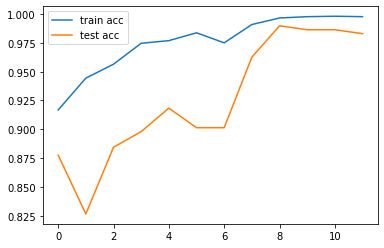

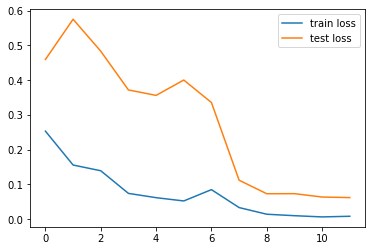

In [26]:
plt.plot(hist.history["accuracy"],label="train acc")
plt.plot(hist.history["val_accuracy"],label="test acc")
plt.legend()
plt.show()

plt.plot(hist.history["loss"],label="train loss")
plt.plot(hist.history["val_loss"],label="test loss")
plt.legend()
plt.show()

In [ ]:
# There is very insignificant overfitting on train. The model is giving a stable output.